<a href="https://colab.research.google.com/github/SatioO/DL_Practices/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

In [0]:
(x, y), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [47]:
print(x.shape, y.shape)

(50000, 32, 32, 3) (50000, 1)


In [0]:
def normalize(x, y):
  x = tf.image.per_image_standardization(x)
  return x, y

ds = tf.data.Dataset.from_tensor_slices((x, y)).map(normalize).batch(256).shuffle(buffer_size=10000)

In [0]:
def VGG16():
  inputs = keras.Input((32, 32, 3))
  # Phase 1
  x = layers.Conv2D(64, (3, 3), padding="SAME", activation='relu')(inputs)
  x = layers.Conv2D(64, (3, 3), padding="SAME", activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2 , 2))(x)
  
  # Phase 2 
  x = layers.Conv2D(128, (3, 3), padding="SAME", activation='relu')(x)
  x = layers.Conv2D(128, (3, 3), padding="SAME", activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2 , 2))(x)

  # Phase 3
  x = layers.Conv2D(256, (3, 3), padding="SAME", activation='relu')(x)
  x = layers.Conv2D(256, (3, 3), padding="SAME", activation='relu')(x)
  x = layers.Conv2D(256, (3, 3), padding="SAME", activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2 , 2))(x)

  # Phase 3
  x = layers.Conv2D(512, (3, 3), padding="SAME", activation='relu')(x)
  x = layers.Conv2D(512, (3, 3), padding="SAME", activation='relu')(x)
  x = layers.Conv2D(512, (3, 3), padding="SAME", activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2 , 2))(x)

  x = layers.Flatten()(x)
  x = layers.Dense(4096, activation='relu')(x)
  x = layers.Dense(4096, activation='relu')(x)
  x = layers.Dense(1000, activation='relu')(x)
  outputs = layers.Dense(10, activation="softmax")(x)
  return keras.Model(inputs=inputs, outputs=outputs)

In [0]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
  print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
  model = VGG16()
  model.compile(
            loss=tf.losses.sparse_categorical_crossentropy,
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
            metrics=['accuracy'])
  
  history = model.fit(ds, epochs=10, validation_data=(x_test, y_test))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Num GPUs Available:  1
Epoch 1/10
196/196 [==============================] - 25s 128ms/step - loss: 1.9330 - accuracy: 0.2921 - val_loss: 2.2968 - val_accuracy: 0.1904
Epoch 2/10
196/196 [==============================] - 24s 123ms/step - loss: 1.6178 - accuracy: 0.4155 - val_loss: 2.1466 - val_accuracy: 0.2303
Epoch 3/10
196/196 [==============================] - 24s 123ms/step - loss: 1.4623 - accuracy: 0.4772 - val_loss: 2.3090 - val_accuracy: 0.1853
Epoch 4/10
196/196 [==============================] - 24s 123ms/step - loss: 1.3448 - accuracy: 0.5201 - val_loss: 2.3711 - val_accuracy: 0.2337
Epoch 5/10
196/196 [==============================] - 24s 123ms/step - loss: 1.2403 - accuracy: 0.5584 - val_loss: 2.0390 - val_accuracy: 0.2751
Epoch 6/10
196/196 [==============================] - 24s 124ms/step - loss: 1.1511 - accuracy: 0.5935 - val_loss: 2.1004 - val_accuracy: 0.2647
Epoch

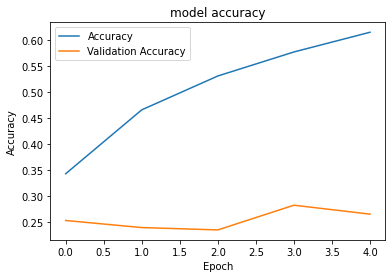

In [44]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()